# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

22:24:27 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=707804;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=819092;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=560554;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=597318;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

22:25:33 INFO      Auto-determined polynomial order: 0                                ]8;id=517204;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=31331;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

22:25:53 INFO      None 0-order polynomial fit with the mle method                               ]8;id=260532;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=790019;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=59607;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=15968;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=587826;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=855160;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

22:25:54 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=795409;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=423464;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=205488;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=540038;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=438739;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=132359;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - observation: poisson                                                       ]8;id=885121;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=584181;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      - background: gaussian                                                       ]8;id=496156;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=149124;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#487\487]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=619112;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=123874;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

22:25:58 INFO      Now using 120 bins                                                          ]8;id=433900;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=668280;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

22:26:01 INFO      Auto-determined polynomial order: 1                                ]8;id=343794;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=896554;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

22:26:24 INFO      None 1-order polynomial fit with the mle method                               ]8;id=335498;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=997937;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=792847;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=335067;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=8084;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=347794;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=114106;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=384267;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=648819;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=136223;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=71067;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=814257;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - observation: poisson                                                       ]8;id=80530;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=56915;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      - background: gaussian                                                       ]8;id=452258;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=191673;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#487\487]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=326474;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=788015;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=591995;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=500892;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

22:26:28 INFO      Auto-determined polynomial order: 1                                ]8;id=78271;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=353165;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

22:26:57 INFO      None 1-order polynomial fit with the mle method                               ]8;id=102187;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=750239;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=301191;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=467110;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=728634;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=102586;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=207930;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=418622;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

22:26:58 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=244956;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=542039;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=562514;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=636945;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - observation: poisson                                                       ]8;id=715662;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=699765;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      - background: gaussian                                                       ]8;id=933769;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=289603;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#487\487]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=65459;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=532105;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=675275;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=840588;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

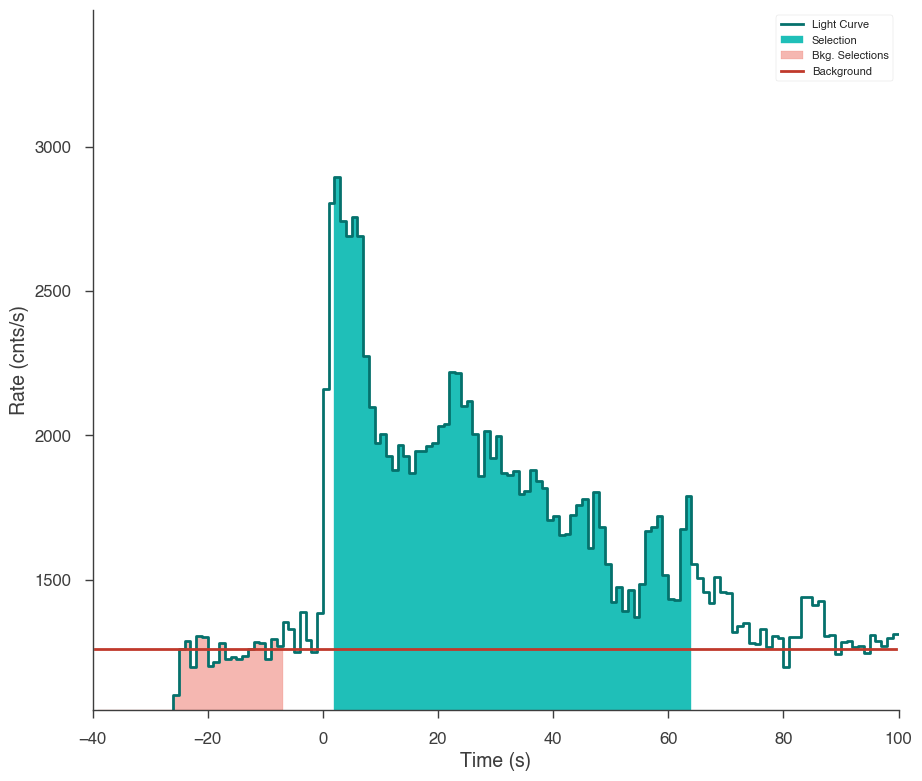

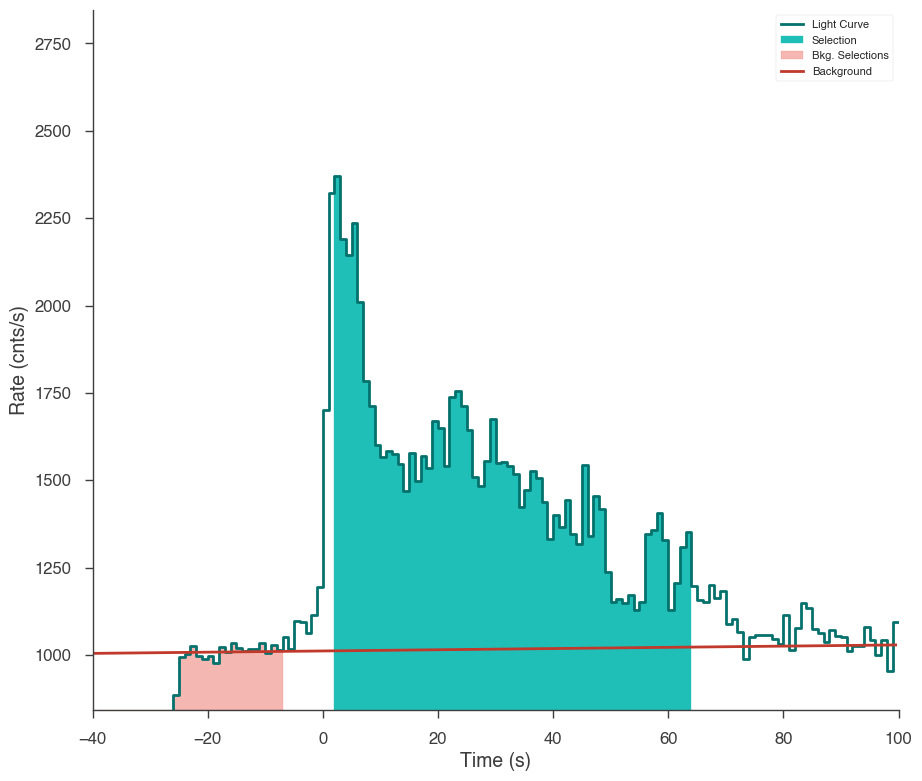

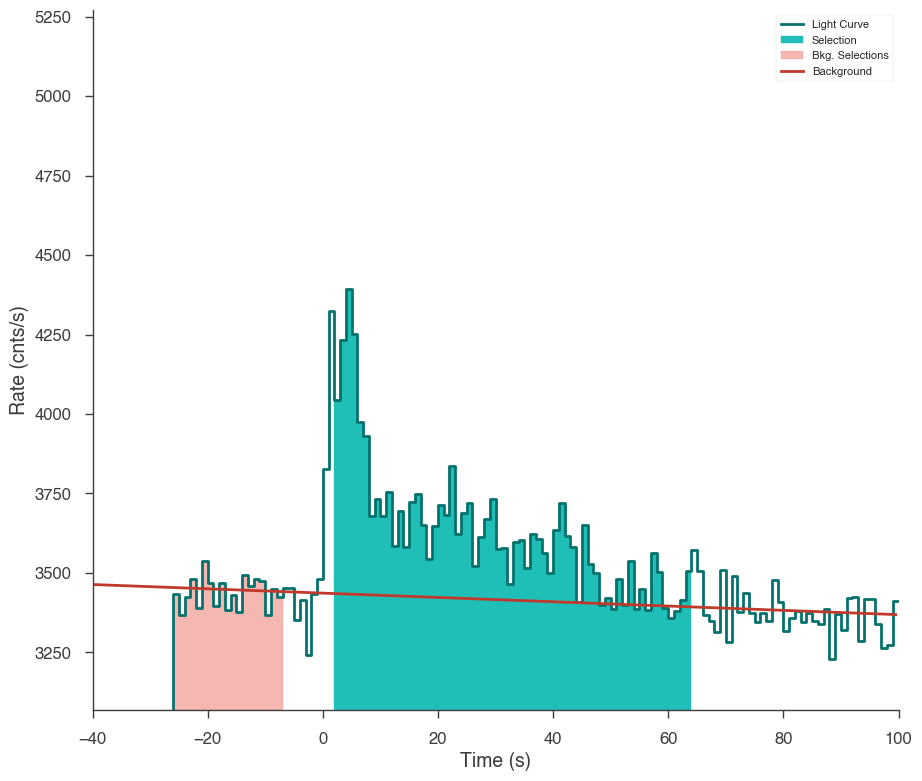

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

22:26:59 INFO      sampler set to multinest                                                ]8;id=563899;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=836303;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

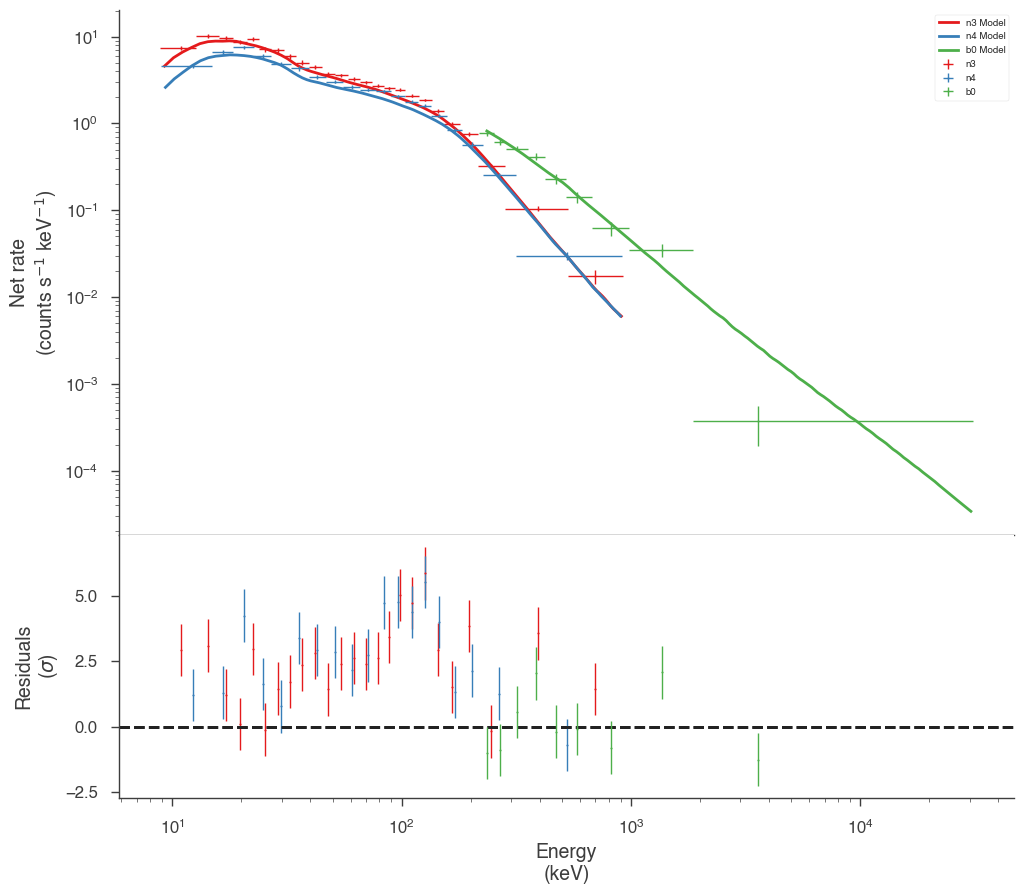

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


 ln(ev)=  -3101.1084061178922      +/-  0.22391795562495789     
 Total Likelihood Evaluations:        24547
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


22:27:32 INFO      fit restored to maximum of posterior                                         ]8;id=981147;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=357447;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=22532;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=669584;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
GRB080916009...K,(1.464 -0.013 +0.024) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.082 -0.010 +0.029,
GRB080916009...break_energy,(1.88 +0.14 +0.7) x 10^2,keV
GRB080916009...break_scale,(0.0 +1.7 +3.4) x 10^-1,
GRB080916009...beta,-1.979 -0.22 -0.033,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0,-1049.284479
n3,-1019.561848
n4,-1010.671377
total,-3079.517704


Values of statistical measures:

,statistical measures
AIC,6169.205862
BIC,6188.438072
DIC,6180.142630
PDIC,4.453092
log(Z),-1346.794269


Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=721706;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=220707;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

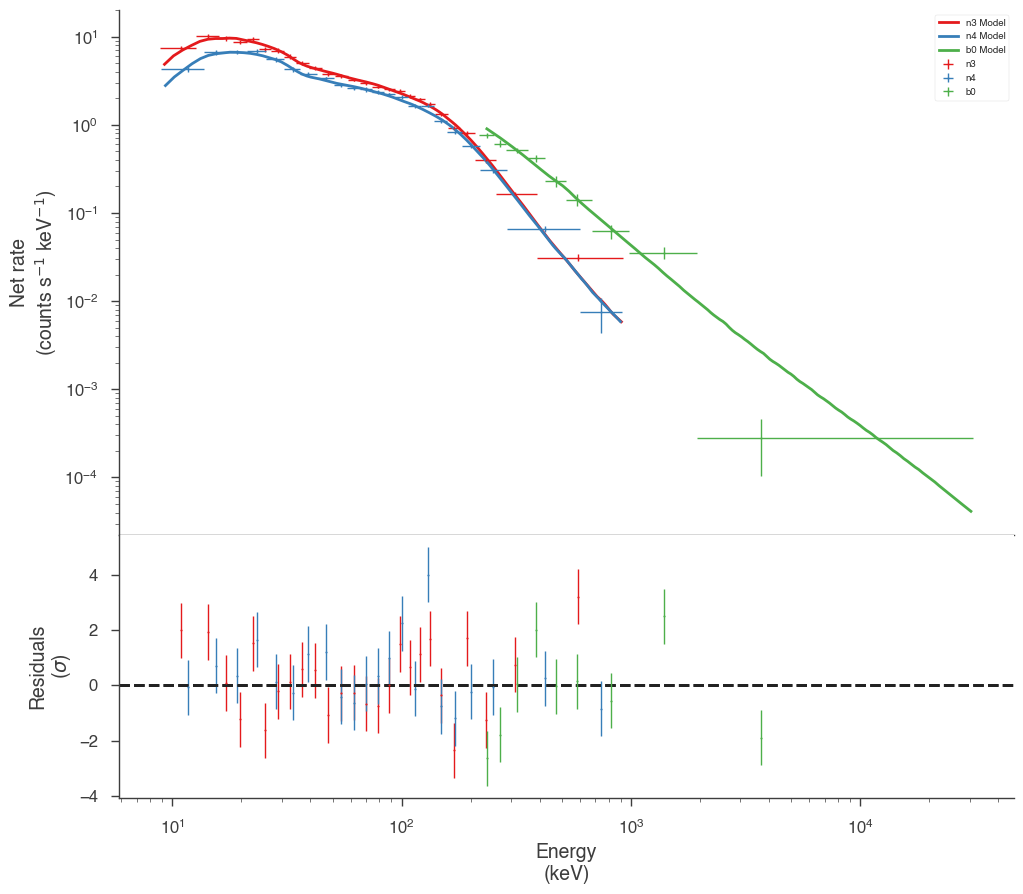

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

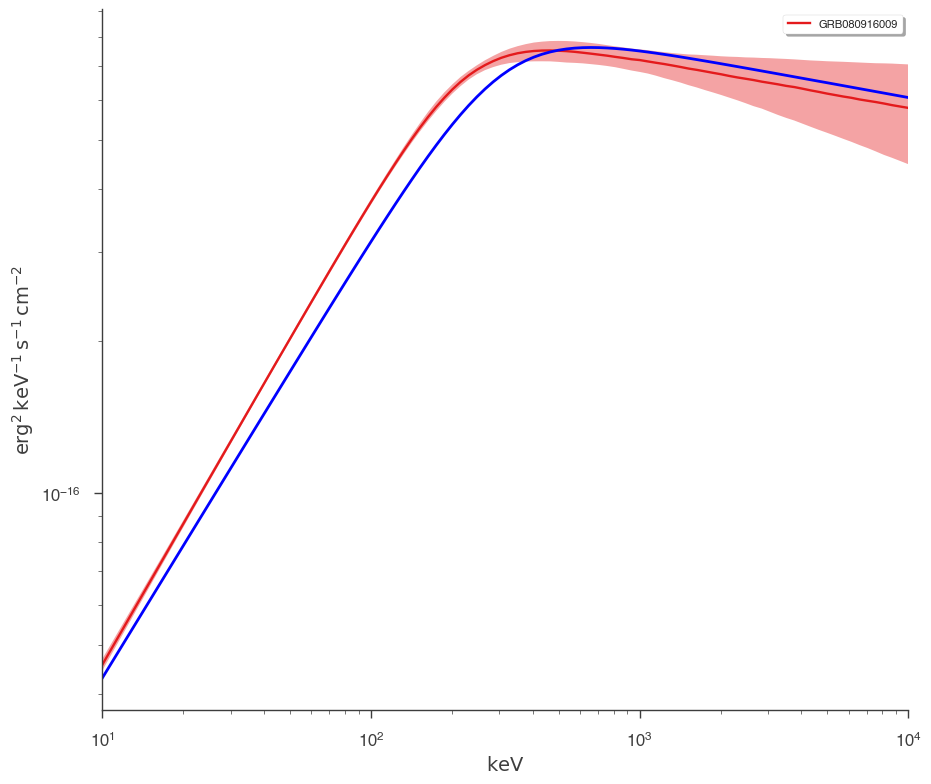

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

22:30:27 INFO      Created 15 bins via bayesblocks                                       ]8;id=10195;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=732453;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


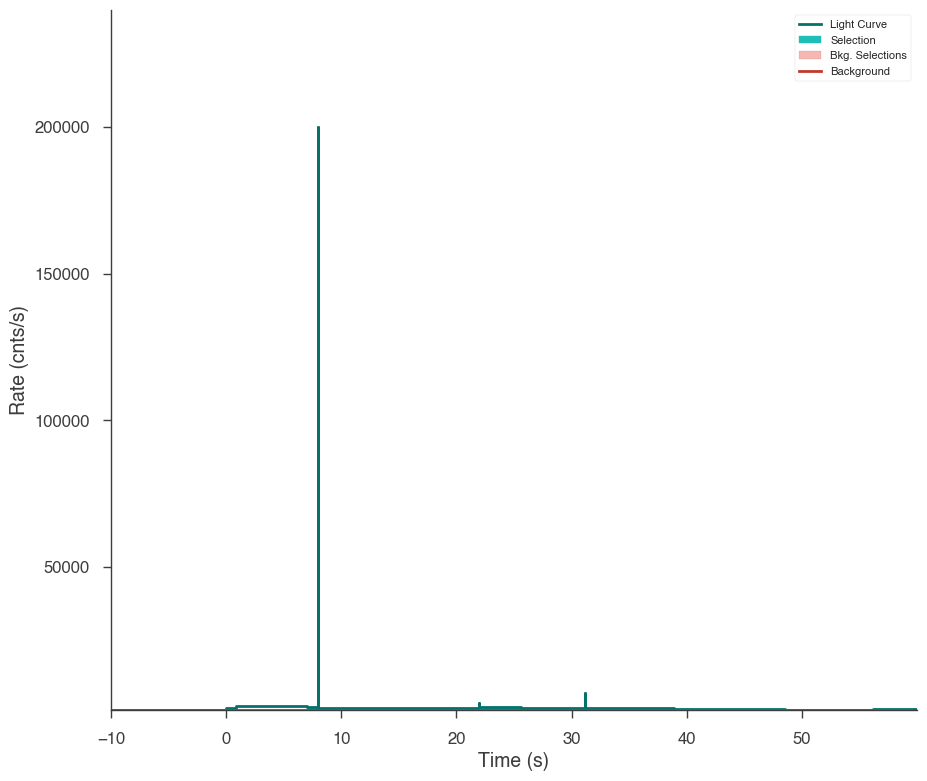

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

         INFO      Created 12 bins via custom                                            ]8;id=639436;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=766530;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

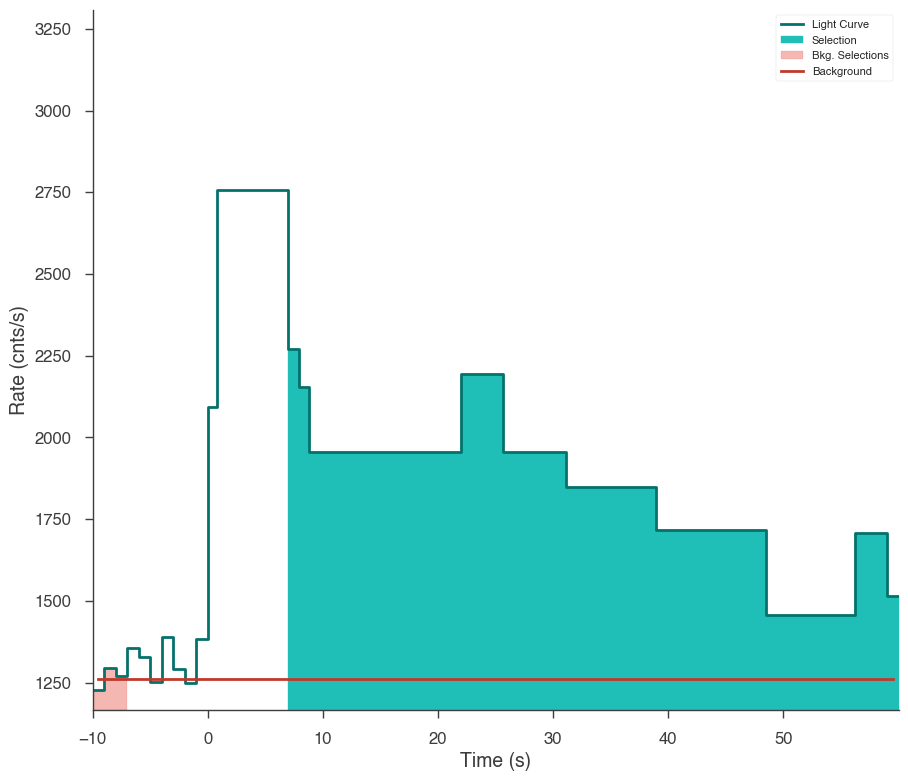

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

22:30:28 INFO      Created 12 bins via custom                                            ]8;id=582428;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=529574;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=989878;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=925260;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

22:30:29 INFO      Created 12 bins via custom                                            ]8;id=756528;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=934318;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=32999;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=56465;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=256694;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=152641;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

22:30:30 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=670501;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=876296;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (None, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=620781;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=530084;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=866097;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=220450;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=826575;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=977;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=992067;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=728251;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=428963;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=400157;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 107 bins                                                          ]8;id=654347;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=151635;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=752616;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=342474;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.40142589944674      +/-  0.17724682385534837     
 Total Likelihood Evaluations:        16953
 Sampling finished. Exiting MultiNest



22:30:49 INFO      fit restored to maximum of posterior                                         ]8;id=977821;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=161380;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=235338;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=500219;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.66 -0.8 +0.19) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.4 -1.8 +0.5) x 10^-1,
grb.spectrum.main.Band.xp,(3.09 -0.21 +1.1) x 10^2,keV
grb.spectrum.main.Band.beta,-2.04 -0.5 +0.06,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval0,-285.627885
n3_interval0,-250.178554
n4_interval0,-267.998251
total,-803.804691


Values of statistical measures:

,statistical measures
AIC,1615.722696
BIC,1631.131513
DIC,1570.891936
PDIC,2.535728
log(Z),-342.398389


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=86168;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=442946;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=202812;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=838509;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=903677;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=509776;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=62285;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=246059;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=238389;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=371292;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=113944;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=8200;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=110828;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=416270;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -1966.2364627564912      +/-  0.21890652727314910     
 Total Likelihood Evaluations:        22999
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


22:31:15 INFO      fit restored to maximum of posterior                                         ]8;id=59288;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=146343;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=666179;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=466029;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(5.404 +0.008 +0.11) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-6.61 -0.09 +0.19) x 10^-1,
grb.spectrum.main.Band.xp,(3.629 -0.09 +0.030) x 10^2,keV
grb.spectrum.main.Band.beta,-1.909 -0.04 +0.029,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval1,-682.665114
n3_interval1,-647.878090
n4_interval1,-644.740690
total,-1975.283894


Values of statistical measures:

,statistical measures
AIC,3958.681102
BIC,3974.089920
DIC,3910.457465
PDIC,2.423957
log(Z),-853.925646


22:31:16 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=782153;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=391930;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=512625;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=722301;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=846210;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=780223;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=978107;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=821315;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=342435;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=348210;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 115 bins                                                          ]8;id=19064;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=803158;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=546498;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=493835;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -908.30311987150333      +/-  0.20515668756947403     
 Total Likelihood Evaluations:        18064
 Sampling finished. Exiting MultiNest



22:31:38 INFO      fit restored to maximum of posterior                                         ]8;id=170347;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=685871;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=78995;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=954365;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.53 -0.21 +0.06) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.062 -0.07 +0.011,
grb.spectrum.main.Band.xp,(6.2 -0.5 +2.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.12 -0.22 -0.06,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval2,-325.138084
n3_interval2,-289.520905
n4_interval2,-312.704709
total,-927.363697


Values of statistical measures:

,statistical measures
AIC,1862.840709
BIC,1878.249527
DIC,1804.539372
PDIC,1.304005
log(Z),-394.471033


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=194387;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=875196;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=992437;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=725393;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=701867;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=282642;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=412718;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=419733;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=210636;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=323731;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 109 bins                                                          ]8;id=370721;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=176578;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=459133;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=242333;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.25317141884216      +/-  0.17610868211954189     
 Total Likelihood Evaluations:        16565
 Sampling finished. Exiting MultiNest



22:31:57 INFO      fit restored to maximum of posterior                                         ]8;id=751660;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=812699;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=243558;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=421271;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.88 -0.28 +0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.2 -0.9 +1.0) x 10^-1,
grb.spectrum.main.Band.xp,(3.4 -0.6 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.23 -0.4 +0.17,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval3,-298.409540
n3_interval3,-242.486326
n4_interval3,-262.572528
total,-803.468394


Values of statistical measures:

,statistical measures
AIC,1615.050102
BIC,1630.458920
DIC,1570.626679
PDIC,3.011328
log(Z),-342.334003


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=167243;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=405052;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=206736;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=68877;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=163197;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=188166;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=353880;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=210245;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=565680;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=122284;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=324529;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=434231;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=368386;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=166424;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2275.7678098910264      +/-  0.20743336201955143     
 Total Likelihood Evaluations:        21211
 Sampling finished. Exiting MultiNest



22:32:22 INFO      fit restored to maximum of posterior                                         ]8;id=226884;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=205860;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=497660;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=994960;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.21 -0.09 +0.16) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.50 -0.25 +0.4) x 10^-1,
grb.spectrum.main.Band.xp,(3.35 -0.4 +0.19) x 10^2,keV
grb.spectrum.main.Band.beta,-1.844 +0.020 +0.07,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval4,-778.842062
n3_interval4,-757.618073
n4_interval4,-746.149954
total,-2282.610089


Values of statistical measures:

,statistical measures
AIC,4573.333493
BIC,4588.742310
DIC,4530.944335
PDIC,2.126085
log(Z),-988.353402


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=213889;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=273357;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=774442;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=868547;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=622831;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=152115;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=881230;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=139153;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=872930;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=455459;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=721246;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=987193;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=472170;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=51051;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1573.2549187237978      +/-  0.19302829125206108     
 Total Likelihood Evaluations:        19066
 Sampling finished. Exiting MultiNest



22:32:44 INFO      fit restored to maximum of posterior                                         ]8;id=444625;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=50259;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=96481;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=76825;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.82 -0.24 +0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.1 -0.6 +0.4) x 10^-1,
grb.spectrum.main.Band.xp,(4.15 -0.31 +0.9) x 10^2,keV
grb.spectrum.main.Band.beta,-2.103 -0.34 +0.013,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval5,-536.750989
n3_interval5,-523.542518
n4_interval5,-527.577308
total,-1587.870815


Values of statistical measures:

,statistical measures
AIC,3183.854944
BIC,3199.263761
DIC,3136.540133
PDIC,3.140478
log(Z),-683.255930


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=740558;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=639378;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=984055;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=347968;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=855073;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=58804;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=202150;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=171150;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=685411;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=696592;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=38204;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=444696;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=458040;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=908092;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1754.6541688131690      +/-  0.18902867803028497     
 Total Likelihood Evaluations:        24015
 Sampling finished. Exiting MultiNest



22:33:10 INFO      fit restored to maximum of posterior                                         ]8;id=541440;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=296168;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=627003;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=848394;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.94 -0.11 +0.14) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.01 +/- 0.05,
grb.spectrum.main.Band.xp,(4.5 -0.6 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-2.33 -0.4 +0.15,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval6,-609.513719
n3_interval6,-584.337755
n4_interval6,-576.821314
total,-1770.672788


Values of statistical measures:

,statistical measures
AIC,3549.458891
BIC,3564.867708
DIC,3501.523444
PDIC,3.506484
log(Z),-762.036623


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=708941;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=411523;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=325913;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=656446;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=863001;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=132260;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=41970;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=672095;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=548210;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=317231;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=272917;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=331578;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=71342;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=299416;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1939.7794468254981      +/-  0.19276214082439666     
 Total Likelihood Evaluations:        19526
 Sampling finished. Exiting MultiNest



22:33:33 INFO      fit restored to maximum of posterior                                         ]8;id=10029;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=799425;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=220149;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=84290;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.67 -0.07 +0.14) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.04 -0.04 +0.05,
grb.spectrum.main.Band.xp,(4.3 +/- 0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-2.27 -0.25 +0.19,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval7,-662.247722
n3_interval7,-640.768808
n4_interval7,-650.580969
total,-1953.597499


Values of statistical measures:

,statistical measures
AIC,3915.308312
BIC,3930.717130
DIC,3868.670929
PDIC,3.322887
log(Z),-842.435510


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=788299;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=233680;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=278863;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=26302;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=132918;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=386564;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=537898;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=477006;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=15406;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=577033;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=268185;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=374553;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=73101;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=489666;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2054.1354099933505      +/-  0.18917149109097989     
 Total Likelihood Evaluations:        18878
 Sampling finished. Exiting MultiNest



22:33:54 INFO      fit restored to maximum of posterior                                         ]8;id=583080;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=936820;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=527309;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=556613;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.54 -0.12 +0.11) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.5 +/- 0.6) x 10^-1,
grb.spectrum.main.Band.xp,(3.7 -0.4 +0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-2.28 -0.4 +0.11,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval8,-702.176245
n3_interval8,-698.433429
n4_interval8,-666.060342
total,-2066.670016


Values of statistical measures:

,statistical measures
AIC,4141.453345
BIC,4156.862163
DIC,4097.609207
PDIC,3.058182
log(Z),-892.099674


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=819051;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=190975;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=623923;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=938433;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=39197;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=396572;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=433320;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=937773;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=708806;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=725095;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=304338;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=250990;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=865893;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=137780;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1878.6419492297107      +/-  0.14539093504104908     
 Total Likelihood Evaluations:        13025
 Sampling finished. Exiting MultiNest



22:34:10 INFO      fit restored to maximum of posterior                                         ]8;id=583098;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=283130;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=247946;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=91210;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.05 -0.30 +1.0) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.8 -1.6 +3.1) x 10^-1,
grb.spectrum.main.Band.xp,(1.2 -0.4 +0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-1.86 -0.30 +0.13,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval9,-648.407354
n3_interval9,-616.980063
n4_interval9,-616.300662
total,-1881.688079


Values of statistical measures:

,statistical measures
AIC,3771.489472
BIC,3786.898289
DIC,3725.844019
PDIC,-20.960142
log(Z),-815.883832


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=449856;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=613314;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=380171;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=884765;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=736698;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=515513;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=426760;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=841578;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=29290;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=90265;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=240413;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=128034;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=883142;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=808460;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1321.8935737434588      +/-  0.16525742419776265     
 Total Likelihood Evaluations:        15568
 Sampling finished. Exiting MultiNest



22:34:28 INFO      fit restored to maximum of posterior                                         ]8;id=530713;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=602404;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=160292;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=923774;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.1 -0.4 +0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.2 -1.4 +1.5) x 10^-1,
grb.spectrum.main.Band.xp,(2.2 -0.4 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-1.98 -0.5 +0.10,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval10,-460.792406
n3_interval10,-437.775881
n4_interval10,-433.253216
total,-1331.821503


Values of statistical measures:

,statistical measures
AIC,2671.756321
BIC,2687.165138
DIC,2633.432537
PDIC,-0.740434
log(Z),-574.091085


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=231277;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=269623;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=936605;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=861555;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=423903;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=87503;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=216185;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=180253;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=878725;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=696528;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=259528;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=683609;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=14148;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=921041;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -811.32541248041457      +/-  0.14277988549436318     
 Total Likelihood Evaluations:        13240
 Sampling finished. Exiting MultiNest



22:34:43 INFO      fit restored to maximum of posterior                                         ]8;id=105654;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=133572;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=49297;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=363417;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.9 -0.8 +2.6) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-4.5 -2.0 +3.3) x 10^-1,
grb.spectrum.main.Band.xp,(1.27 -0.31 +0.26) x 10^2,keV
grb.spectrum.main.Band.beta,-2.10 -0.4 +0.21,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval11,-292.430298
n3_interval11,-272.317588
n4_interval11,-255.994499
total,-820.742386


Values of statistical measures:

,statistical measures
AIC,1649.598086
BIC,1665.006903
DIC,1616.063335
PDIC,-1.256391
log(Z),-352.354150


### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=485767;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=621254;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:34:45 INFO      fit restored to median of posterior                                          ]8;id=766589;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=966005;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:34:46 INFO      fit restored to median of posterior                                          ]8;id=230945;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=646396;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:34:48 INFO      fit restored to median of posterior                                          ]8;id=770249;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=105167;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:34:50 INFO      fit restored to median of posterior                                          ]8;id=141877;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=600978;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=749040;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=992907;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:34:52 INFO      fit restored to median of posterior                                          ]8;id=798502;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=926338;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:34:53 INFO      fit restored to median of posterior                                          ]8;id=967103;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=936335;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:34:54 INFO      fit restored to median of posterior                                          ]8;id=416171;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=167300;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:34:55 INFO      fit restored to median of posterior                                          ]8;id=982290;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=887493;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:34:56 INFO      fit restored to median of posterior                                          ]8;id=597249;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=698662;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:34:57 INFO      fit restored to median of posterior                                          ]8;id=773072;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=974968;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

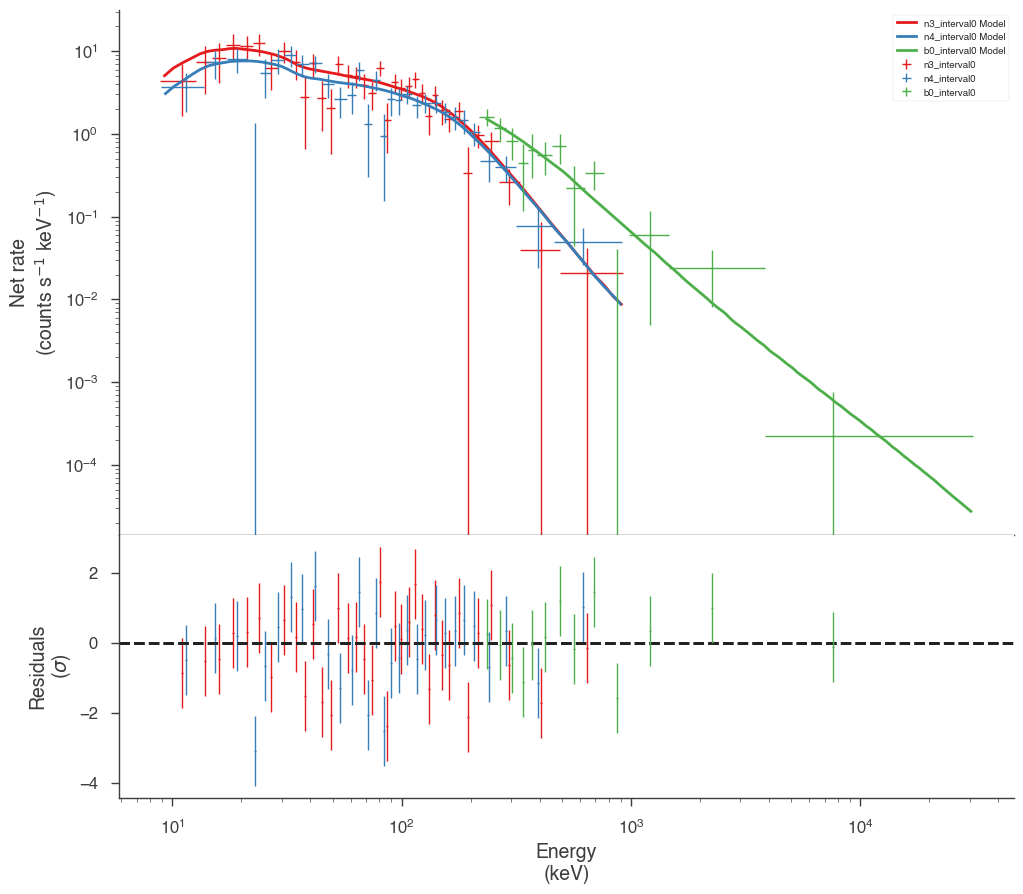

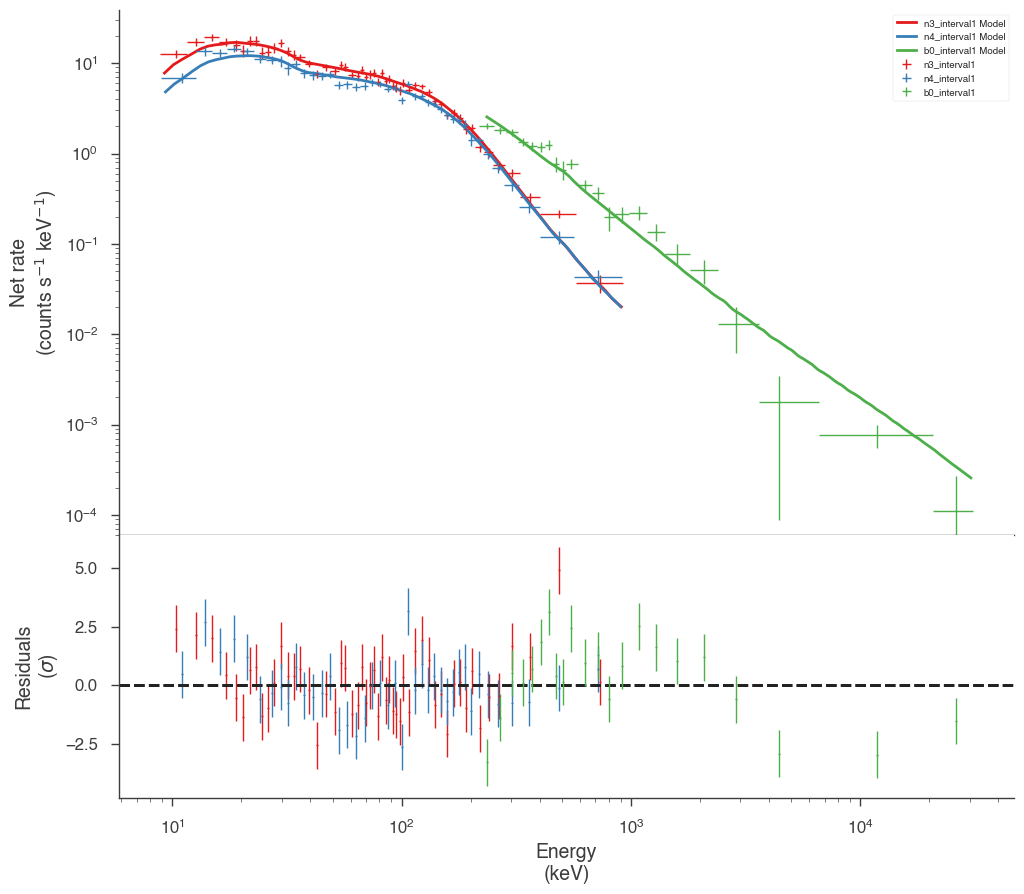

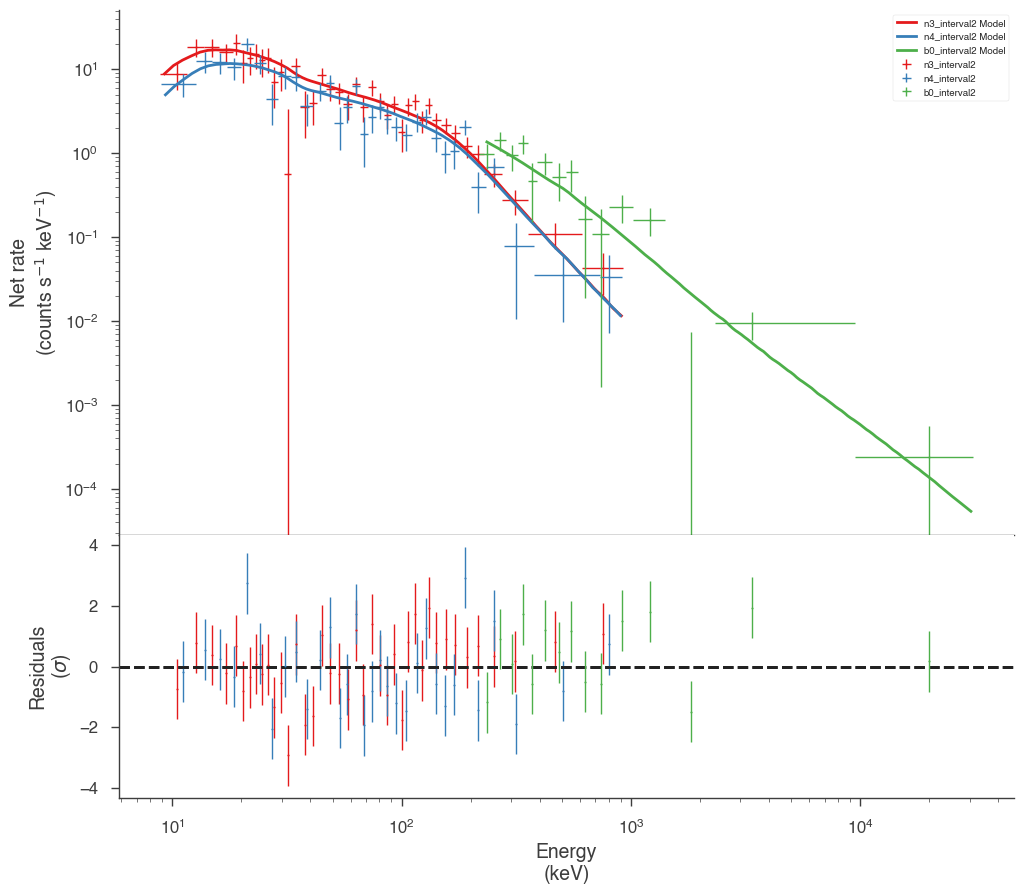

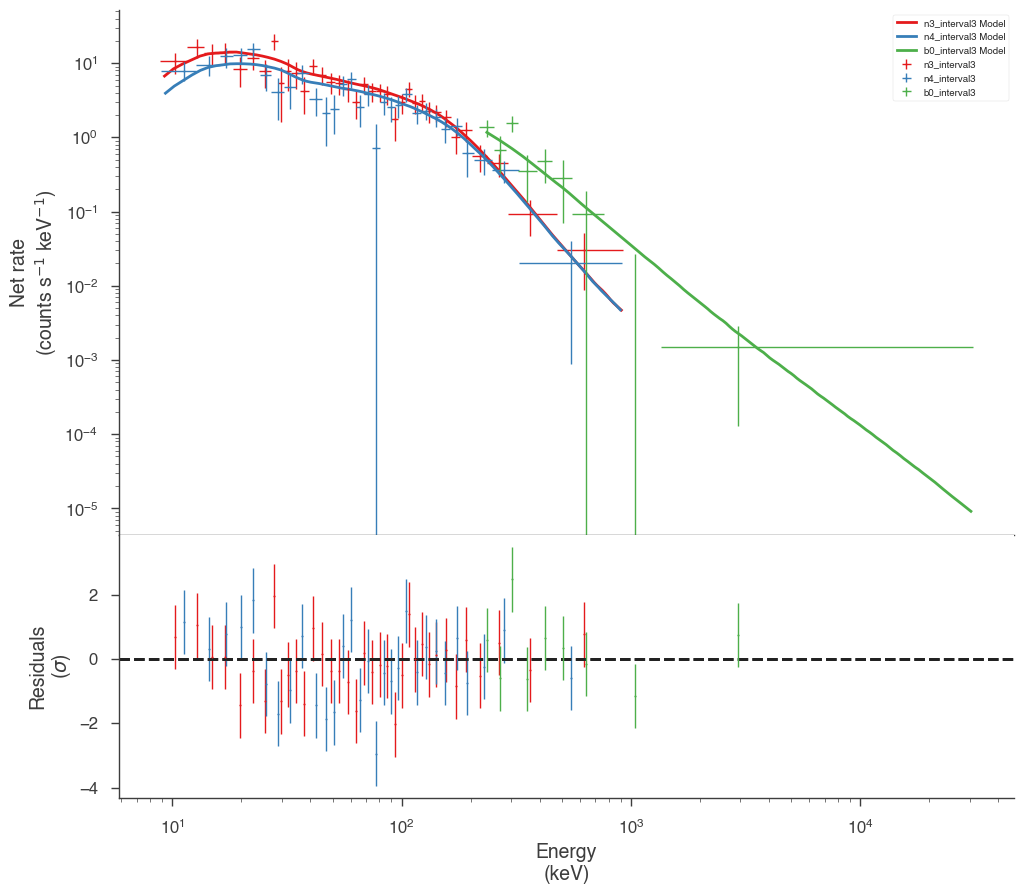

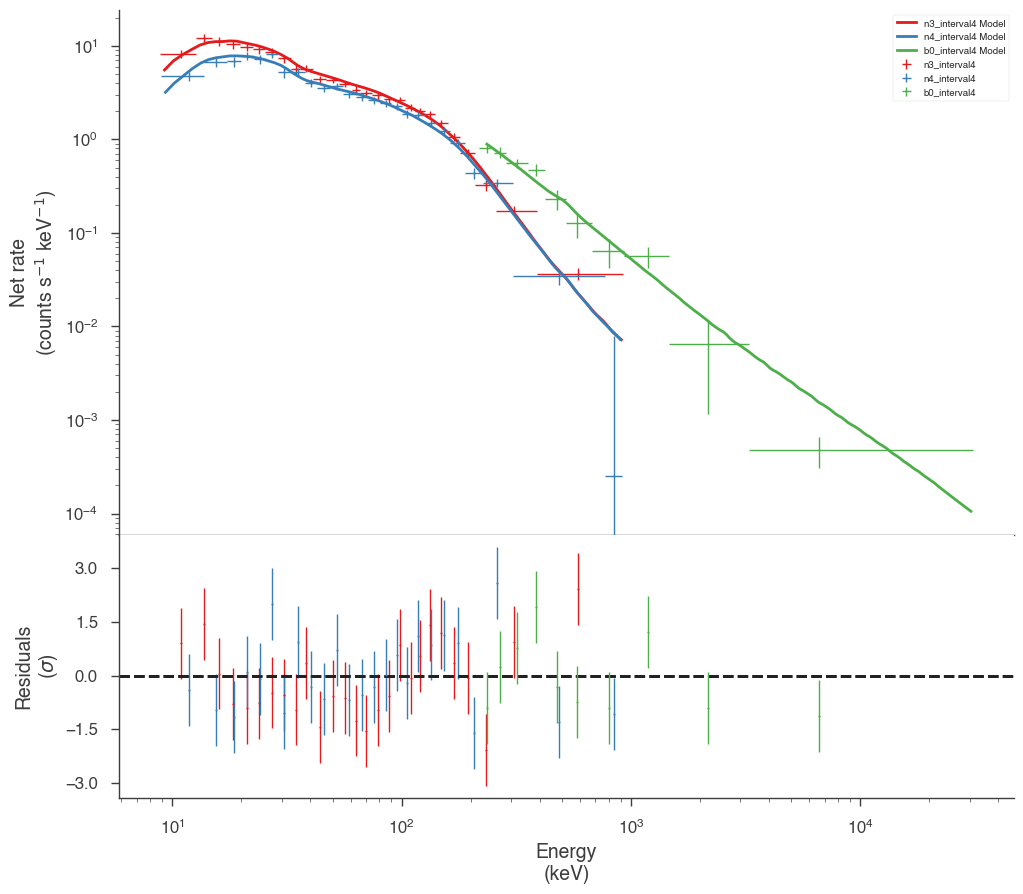

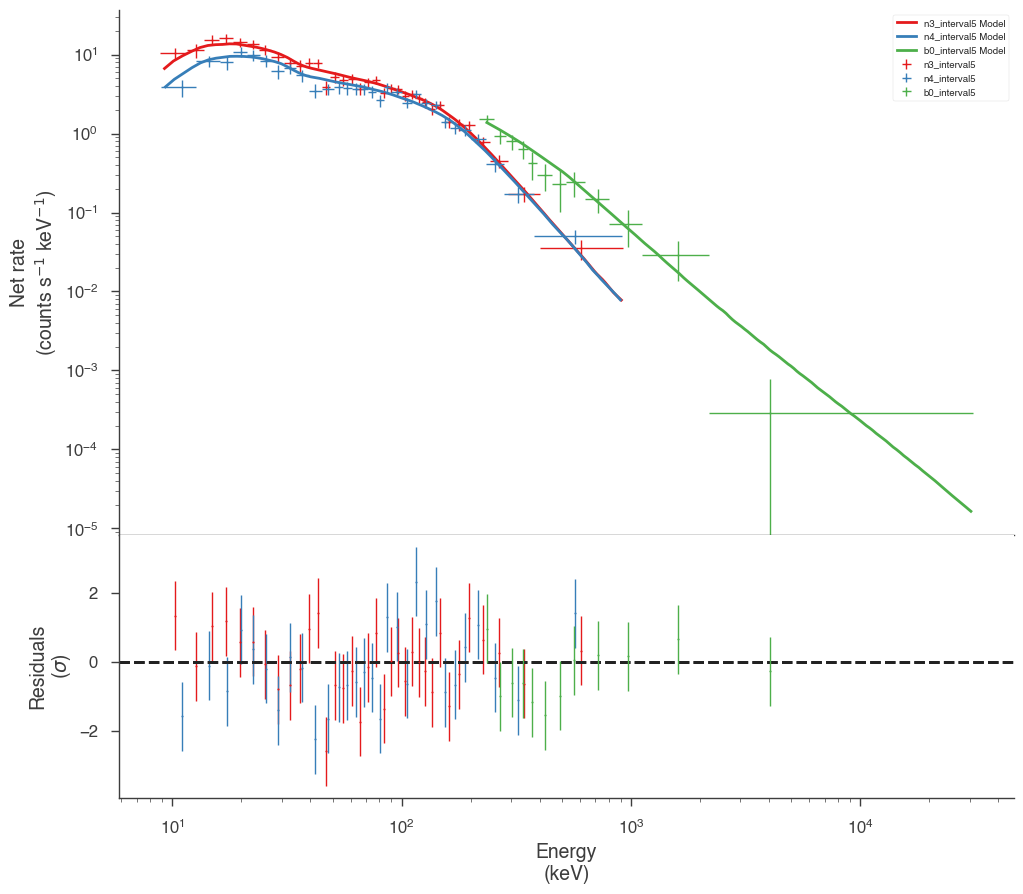

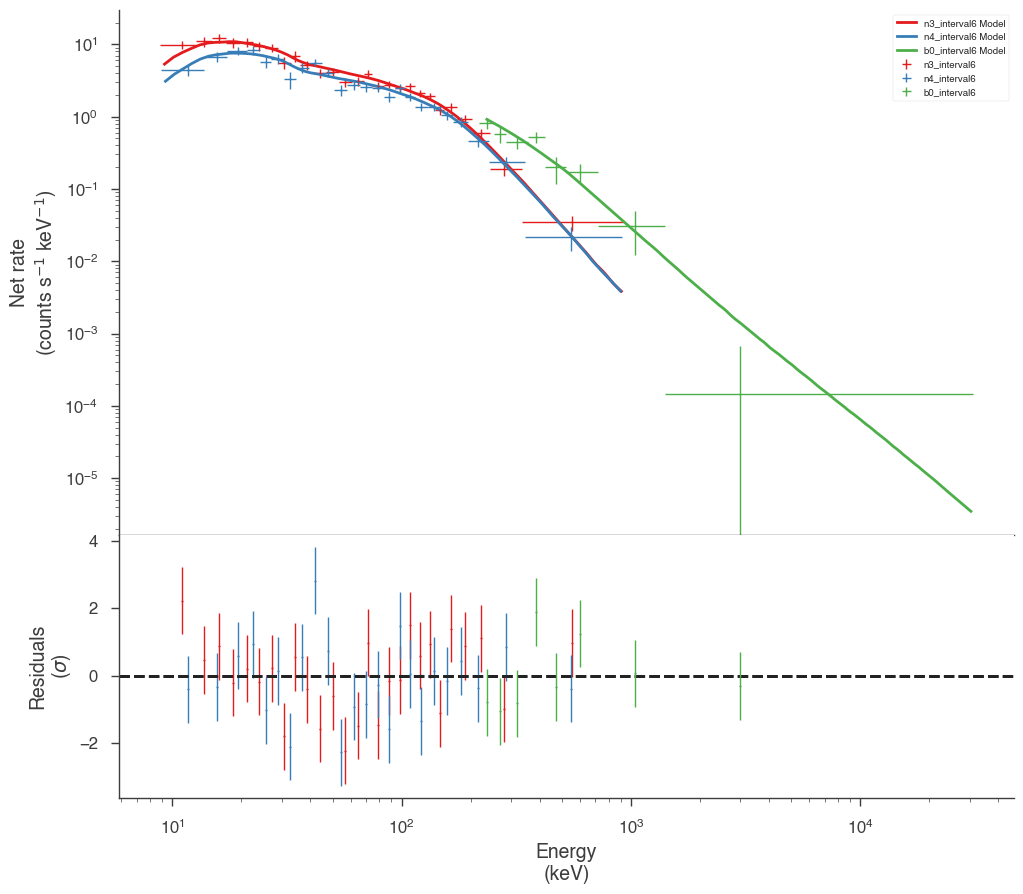

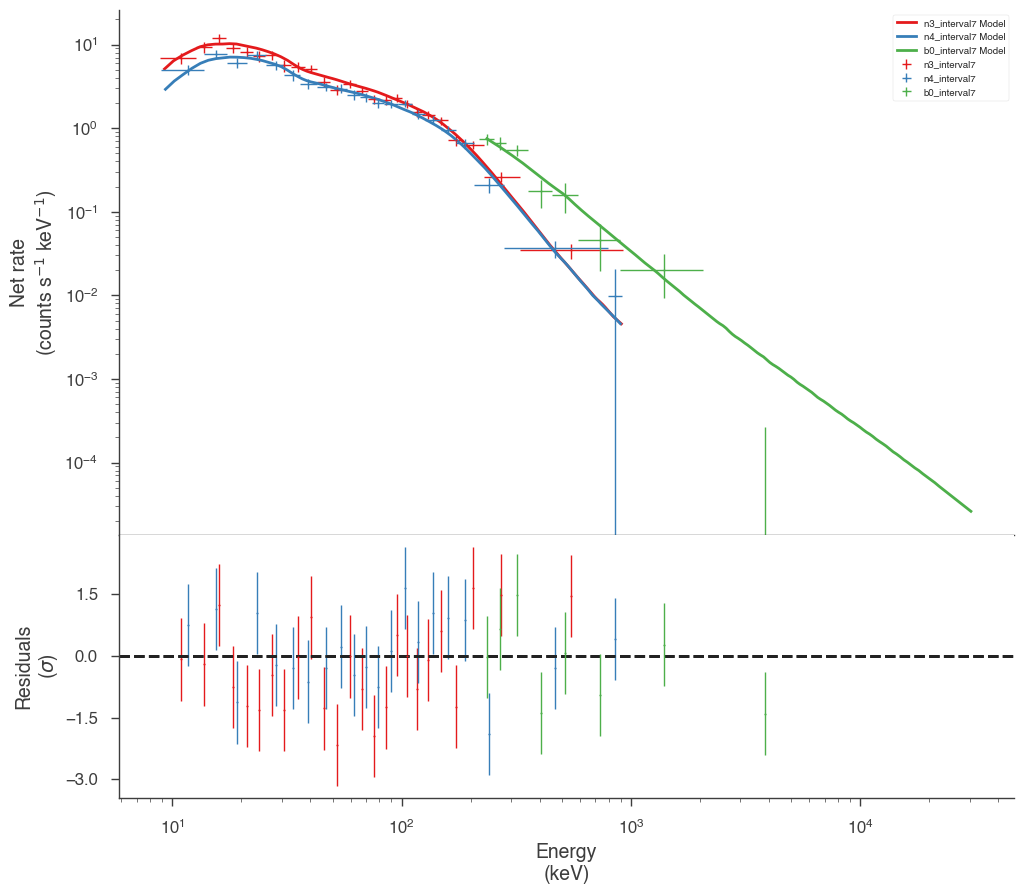

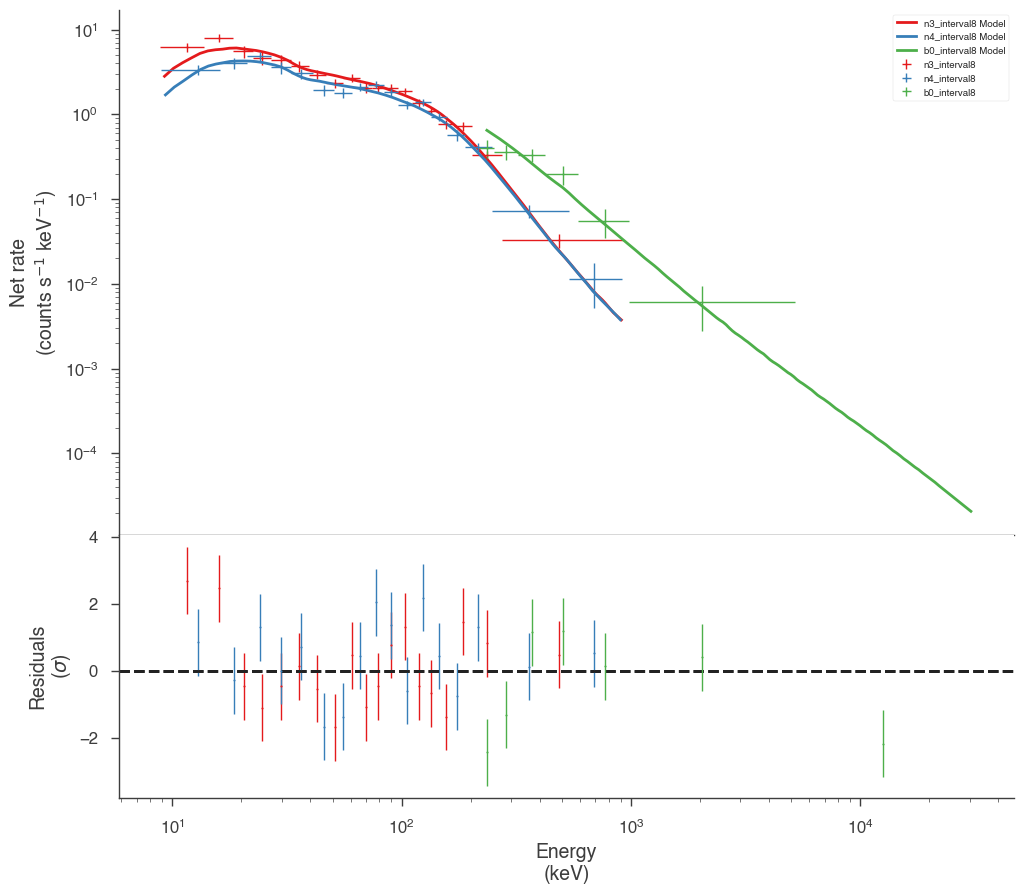

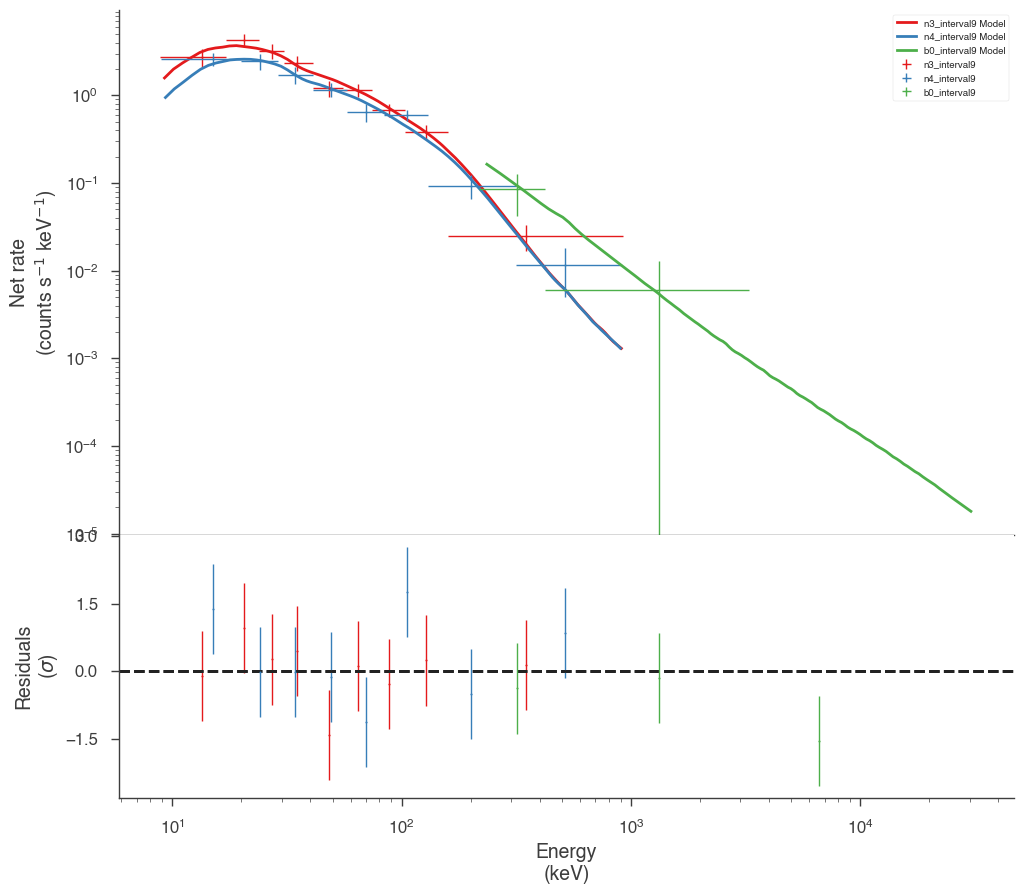

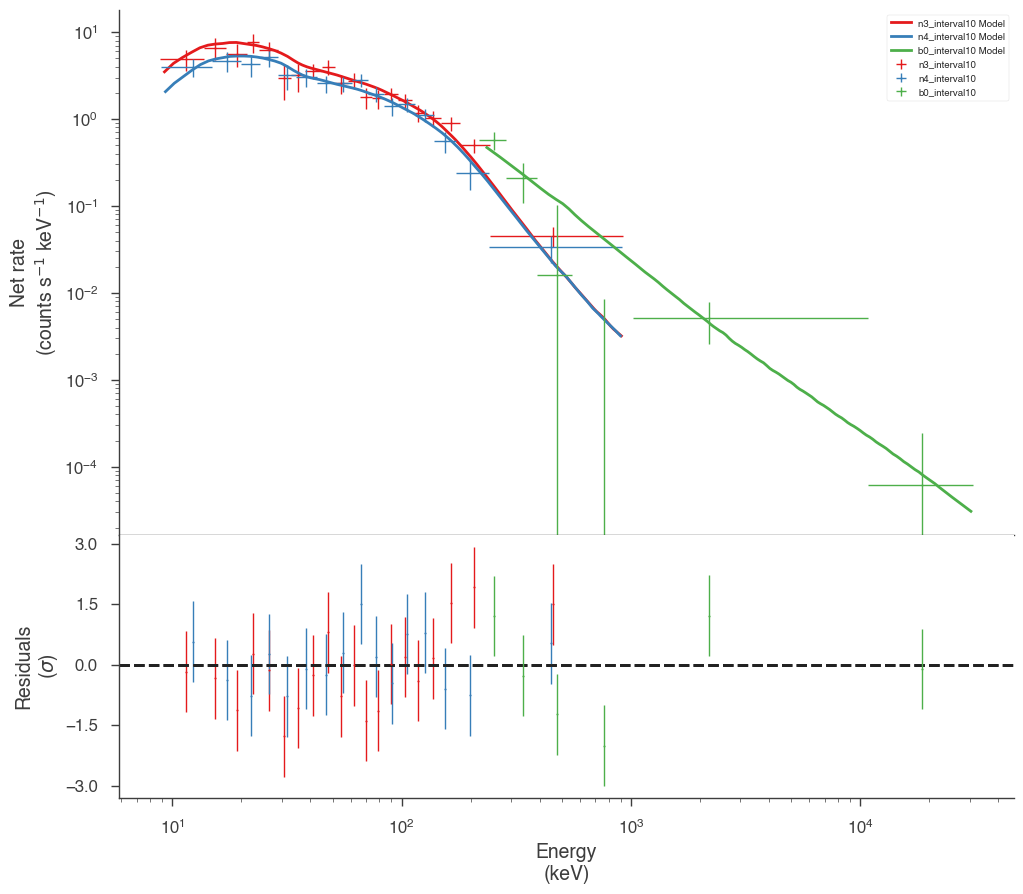

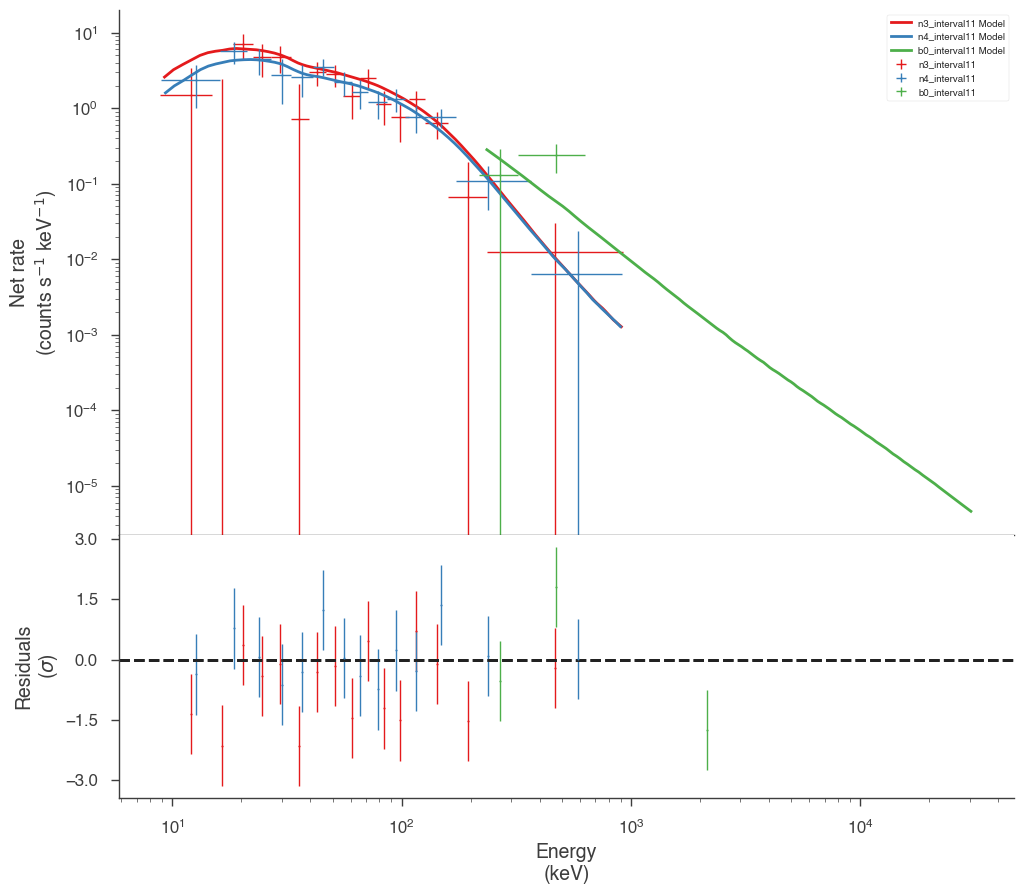

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

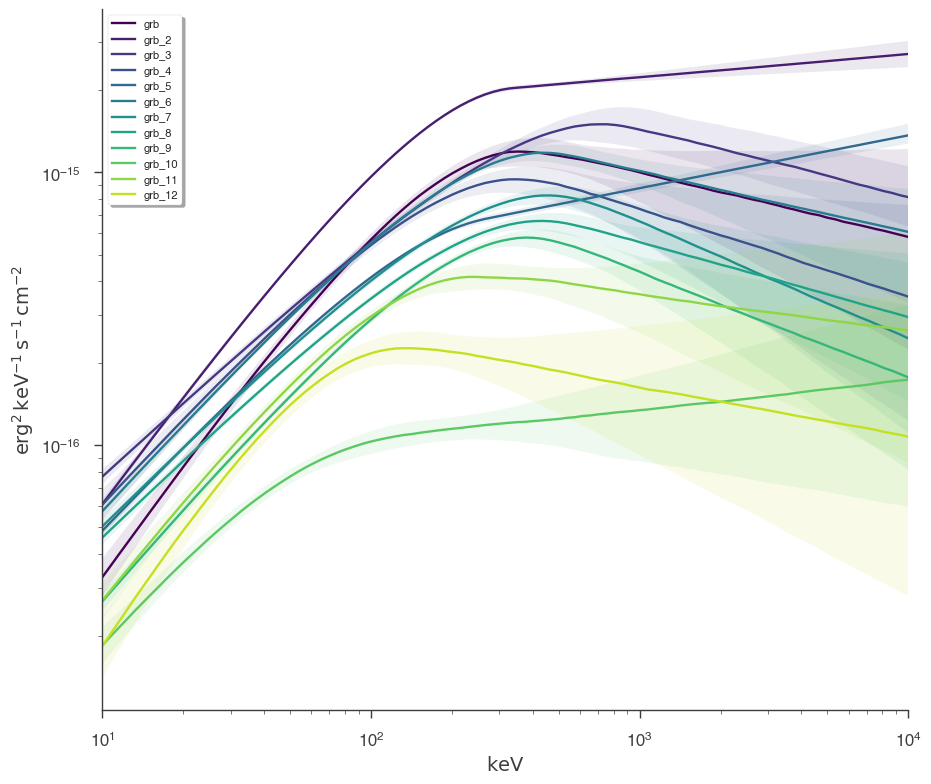

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.